In [1]:
from hetmech.matrix import *
from hetmech.degree_weight import *

In [2]:
import json
import urllib.request
import numpy as np
from scipy import sparse
import hetio.readwrite
import hetio.hetnet
import pandas as pd
import time
import random
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline

## Load the graph and metaedges

In [3]:
%%time
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
graph = hetio.readwrite.read_graph(url)
metagraph = graph.metagraph

CPU times: user 1min 6s, sys: 1.48 s, total: 1min 8s
Wall time: 1min 10s


## Load Metapaths

In [13]:
def load_metapaths():
    """Load 1206 Rephetio metapaths"""
    with urllib.request.urlopen(
        'https://github.com/dhimmel/learn/raw/25093893ed53730ab5cfdac49561c4b6bd3376c5/all-features/data/metapaths.json'
    ) as data_file:
        metapaths = json.loads(data_file.read().decode())
    assert len(metapaths) == 1206
    abbrevs = [metapath['abbreviation'] for metapath in metapaths] # extract str from list(dicts)
    return abbrevs

## See what the breakdown of Rephetio metapaths looks like.

How many are BAAB, etc.
1. No node repeats
2. Any number of nodes repeated once, but disjoint: AXABYBCZC
3. two nodes repeated once, nested: BAAB
4. two nodes repeated once, interleaved: BABA
5. any other situation

In [14]:
all_metapaths = load_metapaths()

In [15]:
all_metapaths[:6]

['CbGaD', 'CbGdD', 'CbGuD', 'CdGaD', 'CdGdD', 'CdGuD']

In [7]:
def remove_unnecessary(string):
    """Removes all characters not integral to the characterization of
    a given metapath. Edges are automatically removed.

    Examples:
    ---------
    'AxByBzC' -> ['B', 'B']
    'AABBCC' -> ['A', 'A', 'B', 'B', 'C', 'C']
    'ABBA' -> ['A', 'B', 'B', 'A']
    'BABA' -> ['B', 'A', 'B', 'A']
    'ABCDEFA' -> ['A', 'A']
    """
    nodes = re.split('[a-z<>]{1,2}', string)
    node_repeats = [v for i, v in enumerate(nodes) if v in nodes[i+1:]]
    ordered_repeats = [node for node in nodes if node in node_repeats]

    return ordered_repeats


In [9]:
disjoint = "AxAxBxB"
no_repeats = "AxBxCxD"
common = "AxBxCxB"
baab = "AxBxBxA"
baba = "AxBxAxB"
triple = "AxAxBxBxDxCxCxA"
multi = "AxAxBxBxDxD"
type_list = [disjoint, no_repeats, common, baab, baba, triple, multi]

In [19]:
def reformat(string):
    """Returns a list of repeated nodes grouped

    Example outputs:
    ----------------
    ['AA', 'BB', 'CC']
    ['ABBA'], ['ABAB'], ['']
    """
    chars_list = remove_unnecessary(string)
    
    # actual functionality to test if the element is part of a repeat    
    repeats_list = [''.join(list(v)) for i, v in itertools.groupby(chars_list)]            
    if len(chars_list) - len(repeats_list) <= 1:
        repeats_list = [''.join(repeats_list)]

    return repeats_list    

In [10]:
def characterize(string):
    """Takes a metapath string and returns a string categorization

    Outputs:
    --------
    no_repeats
        eg. 'ABCD'
    disjoint
        eg. 'ABACDC'
    abba
        eg. 'BAAB'
    abab
        eg. 'BABA'
    Other
        eg. 'ABCABC', 'ABBCCA', 'ABCCBA', etc.
    """
    formatted = reformat(string)
    if not formatted[0]:
        category = "no_repeats"
    elif len(formatted) == 1:
        if len(formatted[0]) < 4:
            category = 'disjoint'
        elif formatted[0][0] == formatted[0][-1]:
            category = 'abba'
        else:
            category = 'abab'
    else:
        if all([i == len(i) * i[0] and len(i) != 1 for i in formatted]):
            category = 'disjoint'
        else:
            category = 'Other'

    return category

In [41]:
for i in type_list:
    print(i, remove_unnecessary(i), reformat(i), all([not len(j)%2 for j in reformat(i)]), characterize(i))

AxAxBxB ['A', 'A', 'B', 'B'] ['AA', 'BB'] True disjoint
AxBxCxD [] [''] True no_repeats
AxBxCxB ['B', 'B'] ['BB'] True disjoint
AxBxBxA ['A', 'B', 'B', 'A'] ['ABBA'] True abba
AxBxAxB ['A', 'B', 'A', 'B'] ['ABAB'] True abab
AxAxBxBxDxCxCxA ['A', 'A', 'B', 'B', 'C', 'C', 'A'] ['AA', 'BB', 'CC', 'A'] False Other
AxAxBxBxDxD ['A', 'A', 'B', 'B', 'D', 'D'] ['AA', 'BB', 'DD'] True disjoint


In [13]:
categories = pd.DataFrame([[v, characterize(v)] for v in all_metapaths], columns=['metapath', 'type'])
categories.head()

,metapath,type
0,CbGaD,no_repeats
1,CbGdD,no_repeats
2,CbGuD,no_repeats
3,CdGaD,no_repeats
4,CdGdD,no_repeats


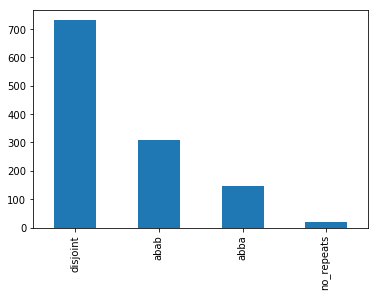

In [14]:
categories.type.value_counts().plot(kind='bar')

In [15]:
categories.loc[categories['type'] == 'disjoint'].head()

,metapath,type
6,CpDrD,disjoint
7,CrCpD,disjoint
8,CrCtD,disjoint
9,CtDrD,disjoint
13,CbG<rGaD,disjoint


In [6]:
metanodes = list(metagraph.metapath_from_abbrev('CtDrD').get_nodes())

In [7]:
metanodes[1] == metanodes[2]

True

In [3]:
def categorize(metapath):
    metanodes = list(metapath.get_nodes())

    if len(metanodes) > 5:
        raise NotImplementedError(
            "Metapaths of that length are not yet supported")

    repeated_nodes = {v for i, v in enumerate(metanodes) if
                      v in metanodes[i + 1:]}

    if len(repeated_nodes) > 2:
        raise NotImplementedError("Only two repeats supported at the moment")

    if not repeated_nodes:
        return 'no_repeats'
    if len(repeated_nodes) == 1:
        return 'disjoint'  # just one repeat = disjoint

    repeats_only = [node for node in metanodes if node in repeated_nodes]

    # Group neighbors if they are the same
    grouped = [list(v) for k, v in itertools.groupby(repeats_only)]

    # Group [A, BB, A] or [A, B, A, B] into one
    if len(repeats_only) - len(grouped) <= 1:
        grouped = [[item for sublist in grouped for item in sublist]]

    # Categorize the reformatted metapath
    if len(grouped) == 1 and len(grouped[0]) == 4:
        if grouped[0][0] == grouped[0][-1]:
            return 'BAAB'
        else:
            return 'BABA'
    else:
        if all([len(set(i)) == 1 and len(i) != 1 for i in grouped]):
            return 'disjoint'
        else:
            return 'other'

In [291]:
for i in all_metapaths:
    print(i, categorize(i))

AttributeError: 'str' object has no attribute 'get_nodes'

In [262]:
categories = pd.DataFrame([[v, categorize(v)] for v in all_metapaths], columns=['metapath', 'type'])
categories.head()

AttributeError: 'str' object has no attribute 'get_nodes'

In [263]:
categories.loc[categories['type'] == 'disjoint2']

,metapath,type


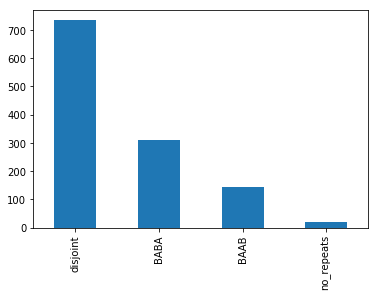

In [264]:
categories.type.value_counts().plot(kind='bar')

In [265]:
df = []
for i in list("ABC"):
    for j in list("ABC"):
        for k in list("ABC"):
            for l in list("ABC"):
                for m in list("ABC"):
                    for n in list("ABC"):
                        df.append([i+j+k+l+m+n, len(i+j+k+l+m+n), len(list(itertools.groupby(i+j+k+l+m+n))), 
                              len(i+j+k+l+m+n) - len(list(itertools.groupby(i+j+k+l+m+n)))])

df = pd.DataFrame(df, columns=['path', 'len', 'grouped', 'diff'])

In [266]:
df.loc[df['diff'] <= 1]

,path,len,grouped,diff
30,AABABA,6,5,1
32,AABABC,6,5,1
33,AABACA,6,5,1
34,AABACB,6,5,1
46,AABCAB,6,5,1
47,AABCAC,6,5,1
48,AABCBA,6,5,1
50,AABCBC,6,5,1
57,AACABA,6,5,1
59,AACABC,6,5,1


In [267]:
a = metagraph.metapath_from_abbrev('CrCrCrCtD')

In [268]:
type(a)

hetio.hetnet.MetaPath

In [269]:
a, b = (1,2 )

In [270]:
a

1

In [271]:
b

2

In [4]:
url = 'https://github.com/dhimmel/hetio/raw/{}/{}'.format(
        '9dc747b8fc4e23ef3437829ffde4d047f2e1bdde',
        'test/data/disease-gene-example-graph.json',
    )
graph = hetio.readwrite.read_graph(url)

In [5]:
edge = ['DlT', 'GaD', 'GiG', 'GeT']
edges = []
for i in edge:
    edges.append(i)
    edges.append(i[::-1])

In [6]:
edges

['DlT', 'TlD', 'GaD', 'DaG', 'GiG', 'GiG', 'GeT', 'TeG']

In [7]:
def follow_one(start):
    ret = list()
    for i, v in enumerate(start):
        start[i] = [v[:-1]+e for e in edges if e[0] == v[-1]]
    start = [i for sublist in start for i in sublist]
    return start

In [8]:
follow_one(["D", "T"])

['DlT', 'DaG', 'TlD', 'TeG']

In [9]:
lst = list("DTG")
while len(lst[-1]) <= 7:
    lst = follow_one(lst)
lst

['DlTlDlTlD',
 'DlTlDlTeG',
 'DlTlDaGaD',
 'DlTlDaGiG',
 'DlTlDaGiG',
 'DlTlDaGeT',
 'DlTeGaDlT',
 'DlTeGaDaG',
 'DlTeGiGaD',
 'DlTeGiGiG',
 'DlTeGiGiG',
 'DlTeGiGeT',
 'DlTeGiGaD',
 'DlTeGiGiG',
 'DlTeGiGiG',
 'DlTeGiGeT',
 'DlTeGeTlD',
 'DlTeGeTeG',
 'DaGaDlTlD',
 'DaGaDlTeG',
 'DaGaDaGaD',
 'DaGaDaGiG',
 'DaGaDaGiG',
 'DaGaDaGeT',
 'DaGiGaDlT',
 'DaGiGaDaG',
 'DaGiGiGaD',
 'DaGiGiGiG',
 'DaGiGiGiG',
 'DaGiGiGeT',
 'DaGiGiGaD',
 'DaGiGiGiG',
 'DaGiGiGiG',
 'DaGiGiGeT',
 'DaGiGeTlD',
 'DaGiGeTeG',
 'DaGiGaDlT',
 'DaGiGaDaG',
 'DaGiGiGaD',
 'DaGiGiGiG',
 'DaGiGiGiG',
 'DaGiGiGeT',
 'DaGiGiGaD',
 'DaGiGiGiG',
 'DaGiGiGiG',
 'DaGiGiGeT',
 'DaGiGeTlD',
 'DaGiGeTeG',
 'DaGeTlDlT',
 'DaGeTlDaG',
 'DaGeTeGaD',
 'DaGeTeGiG',
 'DaGeTeGiG',
 'DaGeTeGeT',
 'TlDlTlDlT',
 'TlDlTlDaG',
 'TlDlTeGaD',
 'TlDlTeGiG',
 'TlDlTeGiG',
 'TlDlTeGeT',
 'TlDaGaDlT',
 'TlDaGaDaG',
 'TlDaGiGaD',
 'TlDaGiGiG',
 'TlDaGiGiG',
 'TlDaGiGeT',
 'TlDaGiGaD',
 'TlDaGiGiG',
 'TlDaGiGiG',
 'TlDaGiGeT',
 'TlDaGeTlD',
 'TlDa

In [10]:
len(lst)

216

In [11]:
for i in lst:
    print(i, categorize(graph.metagraph.metapath_from_abbrev(i)))

DlTlDlTlD other
DlTlDlTeG BABA
DlTlDaGaD disjoint
DlTlDaGiG disjoint
DlTlDaGiG disjoint
DlTlDaGeT BABA
DlTeGaDlT BABA
DlTeGaDaG BABA
DlTeGiGaD BAAB
DlTeGiGiG disjoint
DlTeGiGiG disjoint
DlTeGiGeT BAAB
DlTeGiGaD BAAB
DlTeGiGiG disjoint
DlTeGiGiG disjoint
DlTeGiGeT BAAB
DlTeGeTlD BAAB
DlTeGeTeG BABA
DaGaDlTlD disjoint
DaGaDlTeG BABA
DaGaDaGaD other
DaGaDaGiG other
DaGaDaGiG other
DaGaDaGeT BABA
DaGiGaDlT BAAB
DaGiGaDaG other
DaGiGiGaD other
DaGiGiGiG disjoint
DaGiGiGiG disjoint
DaGiGiGeT disjoint
DaGiGiGaD other
DaGiGiGiG disjoint
DaGiGiGiG disjoint
DaGiGiGeT disjoint
DaGiGeTlD BAAB
DaGiGeTeG disjoint
DaGiGaDlT BAAB
DaGiGaDaG other
DaGiGiGaD other
DaGiGiGiG disjoint
DaGiGiGiG disjoint
DaGiGiGeT disjoint
DaGiGiGaD other
DaGiGiGiG disjoint
DaGiGiGiG disjoint
DaGiGiGeT disjoint
DaGiGeTlD BAAB
DaGiGeTeG disjoint
DaGeTlDlT BABA
DaGeTlDaG BABA
DaGeTeGaD BAAB
DaGeTeGiG disjoint
DaGeTeGiG disjoint
DaGeTeGeT BABA
TlDlTlDlT other
TlDlTlDaG BABA
TlDlTeGaD BABA
TlDlTeGiG disjoint
TlDlTeGiG disjoint


In [252]:
[i.get_id() for i in graph.metagraph.get_nodes()]

['Gene', 'Tissue', 'Disease']

In [14]:
arr

NameError: name 'arr' is not defined